# Course 2 - 改善深层神经网络 - 第一周作业(3) - 梯度校验
1. 初始化参数：
	* 使用0来初始化参数。
	* 使用随机数来初始化参数。
	* 使用抑梯度异常初始化参数（参见视频中的梯度消失和梯度爆炸）。
2. 正则化模型：
	* 使用二范数对二分类模型正则化，尝试避免过拟合。 (`L2正则化`)
	* 使用随机删除节点的方法精简模型，同样是为了尝试避免过拟合。(`dropout正则化`)
3. 梯度校验  ：对模型使用梯度校验，检测它是否在梯度下降的过程中出现误差过大的情况。


## 导入相关库

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import gc_utils     #第三部分，梯度校验
%matplotlib inline

plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 梯度校验
**背景**:

 假设你现在是一个全球移动支付团队中的一员，现在需要建立一个深度学习模型去判断用户账户在进行付款的时候是否是被黑客入侵的。

 但是，在我们执行反向传播的计算过程中，反向传播函数的计算过程是比较复杂的。为了验证我们得到的反向传播函数是否正确，现在你需要编写一些代码来验证反向传播函数的正确性。即使用`gradient checking`。

## 一维线性模型梯度检查过程
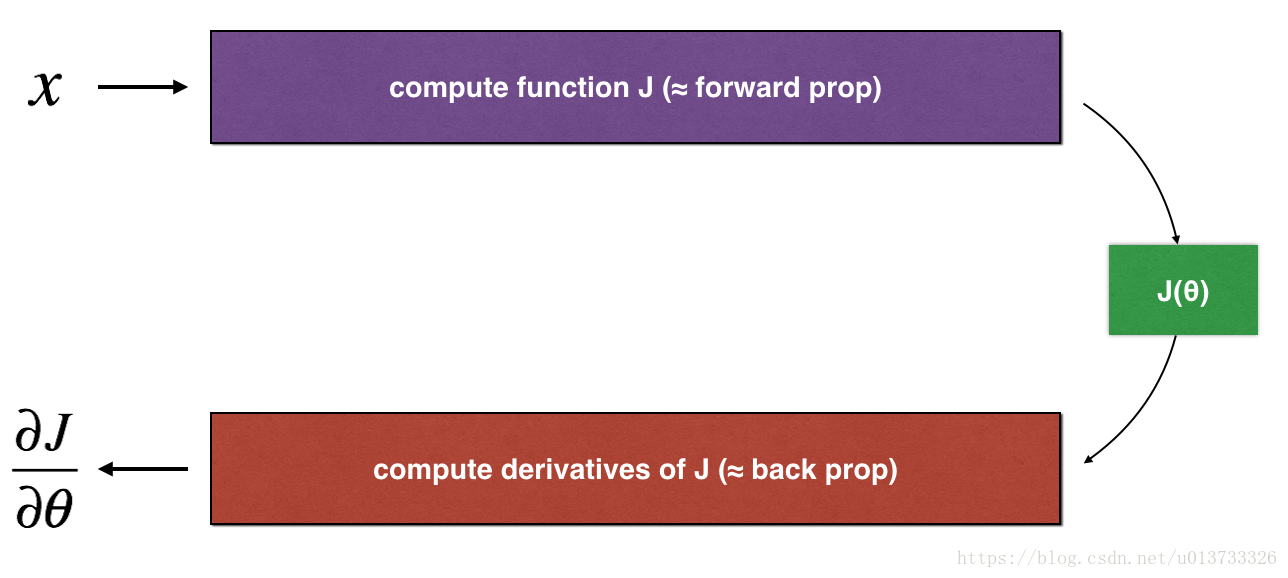

In [2]:
def forward_propagation(x,theta):
    """
    实现图中呈现的线性前向传播（计算J）（J（theta）= theta * x）
    参数：
    x  - 一个实值输入
    theta  - 参数，也是一个实数
    返回：
    J  - 函数J的值，用公式J（theta）= theta * x计算
    """
    J = np.dot(theta,x)
    return J

#测试forward_propagation
print("-----------------测试forward_propagation-----------------")
x, theta = 2, 4
J = forward_propagation(x, theta)
print ("J = " + str(J))

-----------------测试forward_propagation-----------------
J = 8


In [3]:
def backward_propagation(x,theta):
    """
    计算J相对于θ的导数。
    参数：
        x  - 一个实值输入
        theta  - 参数，也是一个实数
    
    返回：
        dtheta  - 相对于θ的成本梯度
    """
    dtheta = x
    return dtheta

#测试backward_propagation
print("-----------------测试backward_propagation-----------------")
x, theta = 2, 4
dtheta = backward_propagation(x, theta)
print ("dtheta = " + str(dtheta))

-----------------测试backward_propagation-----------------
dtheta = 2


梯度检查的步骤如下：
1. $\theta^+ = \theta + \epsilon$
2. $\theta^- = \theta - \epsilon$
3. $J^+ = J(\theta^+)$
4. $J^- = J(\theta^-)$
5. gradapprox = $\frac{J^+ - J^-}{2\epsilon}$
6. 计算梯度的反向传播值，最后计算误差：$difference = \frac{||grad - gradapprox||_2}{||grad||_2 + ||gradapprox||_2}$

当difference小于$10^{-7}$时，我们通常认为我们计算的结果是正确的。

In [4]:
def gradient_check(x,theta,epsilon=1e-7):
    """
    实现图中的反向传播。
    参数：
        x  - 一个实值输入
        theta  - 参数，也是一个实数
        epsilon  - 使用公式（3）计算输入的微小偏移以计算近似梯度
    
    返回：
        近似梯度和后向传播梯度之间的差异
    """
    # 计算gradapprox。
    thetaplus = theta + epsilon                               # Step 1
    thetaminus = theta - epsilon                              # Step 2
    J_plus = forward_propagation(x, thetaplus)                # Step 3
    J_minus = forward_propagation(x, thetaminus)              # Step 4
    gradapprox = (J_plus - J_minus) / (2 * epsilon)           # Step 5
    
    #检查gradapprox是否足够接近backward_propagation（）的输出
    grad = backward_propagation(x, theta)
    
    numerator = np.linalg.norm(grad - gradapprox)  
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)
    difference = numerator / denominator
    
    if difference < 1e-7:
        print("梯度检查：梯度正常!")
    else:
        print("梯度检查：梯度超出阈值!")
    
    return difference

#测试gradient_check
print("-----------------测试gradient_check-----------------")
x, theta = 2, 4
difference = gradient_check(x, theta)
print("difference = " + str(difference))

-----------------测试gradient_check-----------------
梯度检查：梯度正常!
difference = 2.919335883291695e-10


## 多维参数模型梯度检查过程
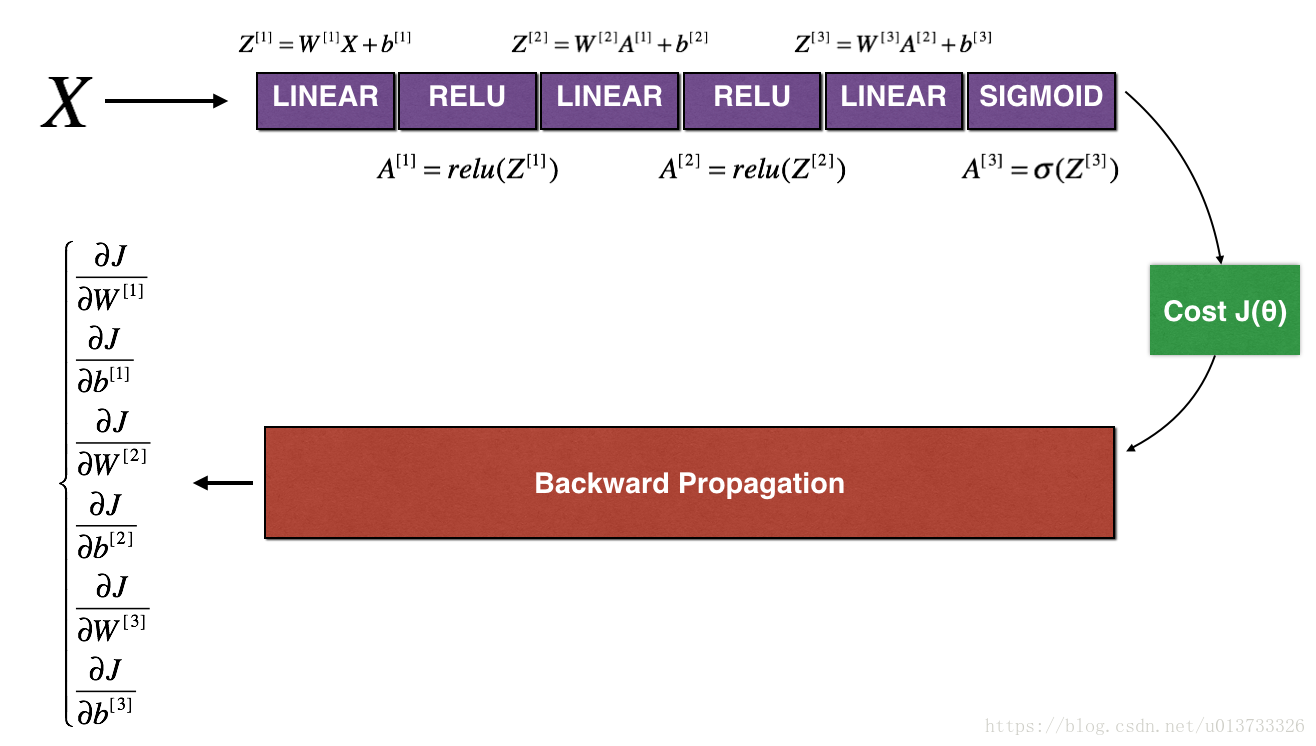

In [5]:
def forward_propagation_n(X,Y,parameters):
    """
    实现图中的前向传播（并计算成本）。
    
    参数：
        X - 训练集为m个例子
        Y -  m个示例的标签
        parameters - 包含参数“W1”，“b1”，“W2”，“b2”，“W3”，“b3”的python字典：
            W1  - 权重矩阵，维度为（5,4）
            b1  - 偏向量，维度为（5,1）
            W2  - 权重矩阵，维度为（3,5）
            b2  - 偏向量，维度为（3,1）
            W3  - 权重矩阵，维度为（1,3）
            b3  - 偏向量，维度为（1,1）
    返回：
        cost - 成本函数（logistic）
    """
    m = X.shape[1]
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1,X) + b1
    A1 = gc_utils.relu(Z1)
    
    Z2 = np.dot(W2,A1) + b2
    A2 = gc_utils.relu(Z2)
    
    Z3 = np.dot(W3,A2) + b3
    A3 = gc_utils.sigmoid(Z3)
    
    #计算成本
    logprobs = np.multiply(-np.log(A3), Y) + np.multiply(-np.log(1 - A3), 1 - Y)
    cost = (1 / m) * np.sum(logprobs)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)

    return cost, cache

def backward_propagation_n(X,Y,cache):
    """
    实现图中所示的反向传播。
    
    参数：
        X - 输入数据点（输入节点数量，1）
        Y - 标签
        cache - 来自forward_propagation_n（）的cache输出
    
    返回：
        gradients - 一个字典，其中包含与每个参数、激活和激活前变量相关的成本梯度。
    """
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1. / m) * np.dot(dZ3,A2.T)
    dW3 = 1. / m * np.dot(dZ3, A2.T)
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1. / m * np.dot(dZ2, A1.T)
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1. / m * np.dot(dZ1, X.T)
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
 
    return gradients

如果想比较“gradapprox”与反向传播计算的梯度。 该公式仍然是：gradapprox = $\frac{J^+ - J^-}{2\epsilon}$

然而，θ不再是标量。 这是一个名为“parameters”的字典。 我们为你实现了一个函数“`dictionary_to_vector()`”。 它将“parameters”字典转换为一个称为“values”的向量，通过将所有参数（W1，b1，W2，b2，W3，b3）整形为向量并将它们连接起来而获得。

反函数是“`vector_to_dictionary`”，它返回“parameters”字典。
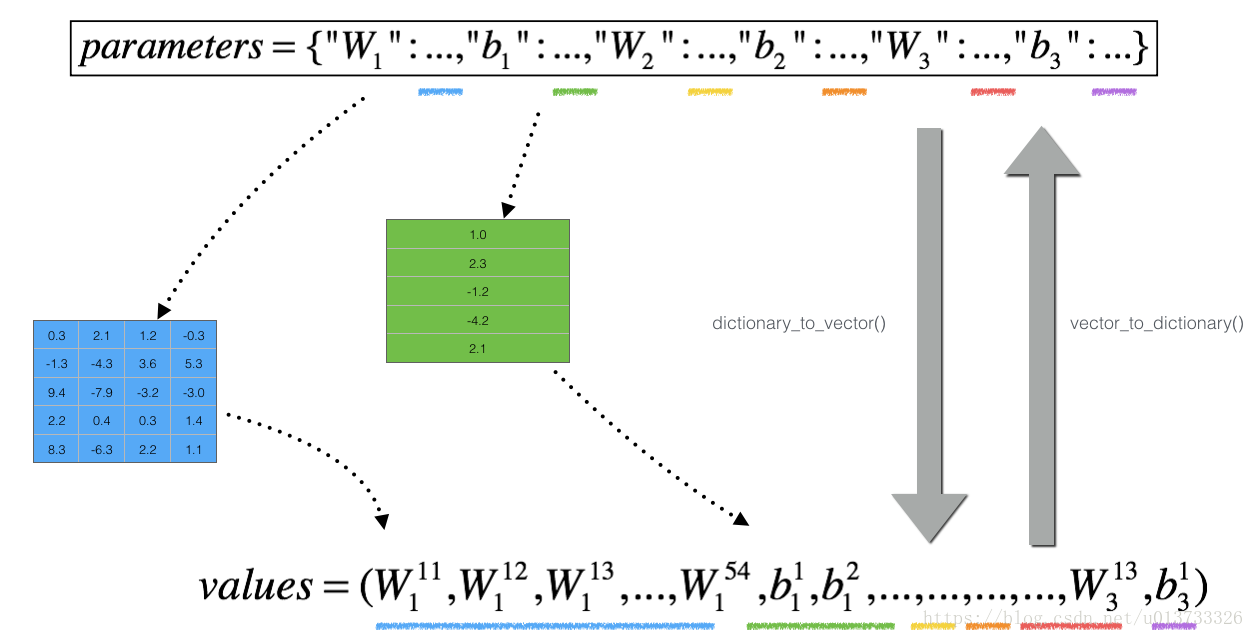

这里是伪代码，可以帮助你实现梯度检查:
For i in num_parameters:
* 计算 `J_plus[i]`:
    1. 把$\theta^+$设置为 `np.copy(parameters_values)`
    2. 把$\theta^+_i$设置为$\theta^+_i + \epsilon$
    3. 使用 forward_propagation_n(x, y, vector_to_dictionary($\theta^+$))来计算$J^+_i$
* 计算 `J_minus[i]`: 使用相同的方法计算 $J_i^-$
* 计算$gradapprox[i] = \frac{J_i^+ - J_i^-}{2\epsilon}$
* 计算梯度
* 计算误差：
$$
difference =  \frac{||grad - gradapprox||_2}{||grad||_2 + ||gradapprox||_2}
$$

In [6]:
def gradient_check_n(parameters,gradients,X,Y,epsilon=1e-7):
    """
    检查backward_propagation_n是否正确计算forward_propagation_n输出的成本梯度
    
    参数：
        parameters - 包含参数“W1”，“b1”，“W2”，“b2”，“W3”，“b3”的python字典：
        gradients - grad_output_propagation_n的输出包含与参数相关的成本梯度。
        x  - 输入数据点，维度为（输入节点数量，1）
        y  - 标签
        epsilon  - 计算输入的微小偏移以计算近似梯度
    
    返回：
        difference - 近似梯度和后向传播梯度之间的差异
    """
    #初始化参数
    parameters_values , keys = gc_utils.dictionary_to_vector(parameters) #keys用不到
    grad = gc_utils.gradients_to_vector(gradients)
    num_parameters = parameters_values.shape[0]
    J_plus = np.zeros((num_parameters,1))
    J_minus = np.zeros((num_parameters,1))
    gradapprox = np.zeros((num_parameters,1))
    
    #计算gradapprox
    for i in range(num_parameters):
        #计算J_plus [i]。输入：“parameters_values，epsilon”。输出=“J_plus [i]”
        thetaplus = np.copy(parameters_values)                                                  # Step 1
        thetaplus[i][0] = thetaplus[i][0] + epsilon                                             # Step 2
        J_plus[i], cache = forward_propagation_n(X,Y,gc_utils.vector_to_dictionary(thetaplus))  # Step 3 ，cache用不到
        
        #计算J_minus [i]。输入：“parameters_values，epsilon”。输出=“J_minus [i]”。
        thetaminus = np.copy(parameters_values)                                                 # Step 1
        thetaminus[i][0] = thetaminus[i][0] - epsilon                                           # Step 2        
        J_minus[i], cache = forward_propagation_n(X,Y,gc_utils.vector_to_dictionary(thetaminus))# Step 3 ，cache用不到
        
        #计算gradapprox[i]
        gradapprox[i] = (J_plus[i] - J_minus[i]) / (2 * epsilon)
        
    #通过计算差异比较gradapprox和后向传播梯度。
    numerator = np.linalg.norm(grad - gradapprox)                                     # Step 1'
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)                   # Step 2'
    difference = numerator / denominator                                              # Step 3'
    
    if difference < 1e-7:
        print("梯度检查：梯度正常!")
    else:
        print("梯度检查：梯度超出阈值!")
    
    return difference
